<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/VAE%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5_%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AE

単に入力を再構成するだけ。

潜在表現は「圧縮されたベクトル」であり、確率的な性質はない。

再構成誤差を閾値化するのが基本。

VAE

潜在表現を「ガウス分布」に従うように制約する。

学習後、潜在空間に「正常データの分布」が構築される。

→ 「再構成誤差＋潜在分布からの外れ度」を同時に見ることができる。

In [30]:
# ======================
# 1. ライブラリ準備
# ======================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [31]:
# ======================
# 2. データ準備 (正常=0, 異常=1)
# ======================
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

x_train = train_dataset.data[train_dataset.targets == 0].float() / 255.0
x_test_normal = test_dataset.data[test_dataset.targets == 0].float() / 255.0
x_test_anomaly = test_dataset.data[test_dataset.targets == 1].float() / 255.0

x_train = x_train.view(-1, 28*28)
x_test_normal = x_test_normal.view(-1, 28*28)
x_test_anomaly = x_test_anomaly.view(-1, 28*28)

train_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=128, shuffle=True)

print("Train:", x_train.shape, "Normal test:", x_test_normal.shape, "Anomaly test:", x_test_anomaly.shape)


Train: torch.Size([5923, 784]) Normal test: torch.Size([980, 784]) Anomaly test: torch.Size([1135, 784])


In [32]:
# ======================
# 3. VAE モデル定義
# ======================
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super(VAE, self).__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [33]:
# ======================
# 4. 損失関数 (再構成誤差 + KL)
# ======================
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    # KL divergence: D_KL(q(z|x) || N(0,1))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl) / x.size(0)


In [34]:
# ======================
# 5. 学習
# ======================
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch_x)
        loss = vae_loss(recon, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 76.9868
Epoch 2/20, Loss: 49.3835
Epoch 3/20, Loss: 42.8711
Epoch 4/20, Loss: 40.6587
Epoch 5/20, Loss: 38.5376
Epoch 6/20, Loss: 36.9375
Epoch 7/20, Loss: 36.0554
Epoch 8/20, Loss: 35.4477
Epoch 9/20, Loss: 35.1328
Epoch 10/20, Loss: 34.8644
Epoch 11/20, Loss: 34.6358
Epoch 12/20, Loss: 34.3837
Epoch 13/20, Loss: 34.1968
Epoch 14/20, Loss: 34.0482
Epoch 15/20, Loss: 33.7557
Epoch 16/20, Loss: 33.6145
Epoch 17/20, Loss: 33.2801
Epoch 18/20, Loss: 33.2629
Epoch 19/20, Loss: 32.9555
Epoch 20/20, Loss: 32.8818


In [35]:
# ======================
# 6. 異常スコア計算 (再構成誤差 + KL)
# ======================
def anomaly_scores(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        recon, mu, logvar = model(x)
        recon_error = torch.mean((x - recon)**2, dim=1)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) / x.size(1)
        score = recon_error + kl  # 両方を足す
    return score.cpu().numpy()

scores_normal = anomaly_scores(x_test_normal)
scores_anomaly = anomaly_scores(x_test_anomaly)

threshold = np.percentile(scores_normal, 95)
print("Threshold:", threshold)
print("正常→異常誤判率:", np.mean(scores_normal > threshold))
print("異常→正しく異常判定率:", np.mean(scores_anomaly > threshold))


Threshold: 0.070542224
正常→異常誤判率: 0.05
異常→正しく異常判定率: 0.9947136563876652


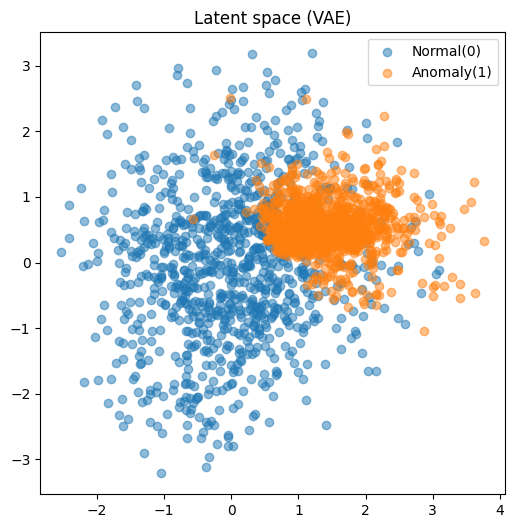

In [36]:
# ======================
# 7. 潜在空間の可視化
# ======================
def latent_distribution(x, label):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.to(device))
        z = mu.cpu().numpy()
    return z

z_normal = latent_distribution(x_test_normal, 0)
z_anomaly = latent_distribution(x_test_anomaly, 1)

plt.figure(figsize=(6,6))
plt.scatter(z_normal[:,0], z_normal[:,1], alpha=0.5, label="Normal(0)")
plt.scatter(z_anomaly[:,0], z_anomaly[:,1], alpha=0.5, label="Anomaly(1)")
plt.legend()
plt.title("Latent space (VAE)")
plt.show()
